<!-- Copyright 2015 Google Inc. All rights reserved. -->

<!-- Licensed under the Apache License, Version 2.0 (the "License"); -->
<!-- you may not use this file except in compliance with the License. -->
<!-- You may obtain a copy of the License at -->

<!--     http://www.apache.org/licenses/LICENSE-2.0 -->

<!-- Unless required by applicable law or agreed to in writing, software -->
<!-- distributed under the License is distributed on an "AS IS" BASIS, -->
<!-- WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. -->
<!-- See the License for the specific language governing permissions and -->
<!-- limitations under the License. -->

# Exploring Linkage Disequilibrium Data
This notebook demonstrates working with linkage disequilibrium (LD) data stored as publicly accessible BigQuery datasets.
Specifically, we will work with LD calculated on the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) variants. The source variants were imported to Google Genomics and then LD calculations were performed on various subsets of the data, including all 26 populations in their own datasets as well as on the five [superpopulations](http://www.1000genomes.org/faq/which-populations-are-part-your-study) aggregated separately. The resulting datasets were exported to BigQuery using pipelines in the https://github.com/googlegenomics/linkage-disequilibrium project.

If you want to explore more genomics samples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Datalab instance by uploading them while on the notebook list page.

In [103]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
# Get references to the BigQuery tables of linkage disequilibrium
# in the five superpopulations of the 1000 Genomes Project
# (http://www.1000genomes.org/faq/which-populations-are-part-your-study):
# AMR: Admixed American
# AFR: African
# EUR: European
# SAS: South Asian
# EAS: East Asian
populations = {
  "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
  "AMR": ["CLM", "MXL", "PEL", "PUR"],
  "EAS": ["CDX", "CHB", "CHS", "JPT", "KHV"],
  "EUR": ["CEU", "FIN", "GBR", "IBS", "TSI"],
  "SAS": ["BEB", "GIH", "ITU", "PJL", "STU"],
}

POPULATION_PLOT_ORDER = ["AMR", "AFR", "EUR", "SAS", "EAS"]

def get_ld_tablename(population):
  """Returns the name of the BigQuery table with the publicly-available LD data."""
  return "genomics-public-data:linkage_disequilibrium_1000G_phase_3.super_pop_%s" % population

tables = {}
for superpopulation, subpopulations in populations.iteritems():
  # Only load the superpopulations for this analysis.
  tables[superpopulation] = bq.Table(get_ld_tablename(superpopulation))

tables["EUR"].length

3029459736

## Visualizing the extent of LD across populations
As the above result shows, there are over 3 billion LD results in the European dataset! That's because the 1000 Genomes Phase 3 data has over 80 million variants in it, and LD is computed between pairs of variants--even with the reduction of data stored by windowing and pruning pairs with low LD, there is still a lot of data.

The following analysis will display the total number of LD result pairs on each chromosome separately for each of the five superpopulations. Note that the count values in the query is divided by two since each pair of LD results appears twice in the table.

In [105]:
%%sql --module ld_count_distributions
SELECT
  qchrom,
  count(*) / 2 AS num_pairs
FROM $all_ld_table
GROUP BY qchrom

In [106]:
# Load LD result pair counts for each superpopulation.
ld_counts = {}
for superpopulation in populations:
  table = tables[superpopulation]
  ld_counts[superpopulation] = bq.Query(ld_count_distributions,
                                        all_ld_table=table).to_dataframe()
  ld_counts[superpopulation].rename(columns={"num_pairs": superpopulation},
                                    inplace=True)

# Merge all LD result pair counts into a single dataframe.
merged_counts = None
for superpopulation in POPULATION_PLOT_ORDER:
  counts = ld_counts[superpopulation]
  if merged_counts is None:
    merged_counts = counts
  else:
    merged_counts = pd.merge(merged_counts, counts, on="qchrom", how="inner")
merged_counts["qchrom"] = merged_counts["qchrom"].astype(int)
merged_counts.sort("qchrom", inplace=True)

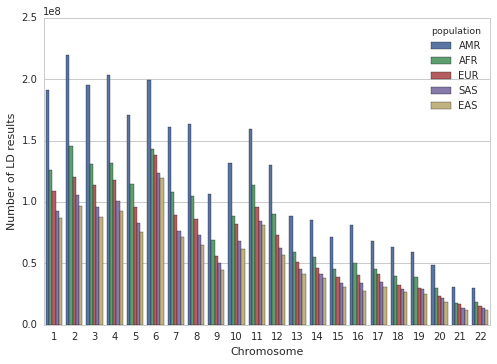

In [107]:
# Plot the LD result pair counts by chromosome and superpopulation.
melted_counts = pd.melt(merged_counts,
                        id_vars="qchrom",
                        var_name="population",
                        value_name="num_results")
sns.set_style("whitegrid")
sns.barplot(x="qchrom", y="num_results", hue="population", data=melted_counts)
sns.axlabel("Chromosome", "Number of LD results")

The above results show a consistent trend, where the number of LD results per chromosome is greatest for the Admixed American superpopulation (AMR), followed by African (AFR), European (EUR), South Asian (SAS), and finally East Asian (EAS). While the presence of more LD results in AMR is expected due to population stratification ([Hinrichs et al. 2009](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3133943)), the presence of more LD in AFR than EUR is unexpected. The result likely indicates substantial population stratification within the AFR superpopulation, and a need for care in addressing it when performing association studies in a heterogeneous "African" population.

We can investigate this more detail by examining the distributions of linkage disequilibrium results, performed below.

In [108]:
def merge_summary_stats(data_dict, populations=None):
  """Returns a pandas DataFrame of all summary stats for all populations.
  
  Args:
    data_dict: A dictionary keyed by population with value a DataFrame
        containing mean, stdev, and quartile information about a metric.
    populations: A list of keys of the data dictionary to include in the
        result.
        
  Returns:
    A single DataFrame with all summary statistics for all populations
        present in the input data dictionary.
  """
  if populations is None:
    populations = sorted(data_dict.keys())

  merged_dict = {"population": [],
                 "mean": [],
                 "stdev": [],
                 "min": [],
                 "max": [],
                 "q1": [],
                 "median": [],
                 "q3": []}
  
  for population in populations:
    metrics_table = data_dict[population]
    merged_dict["population"].append(population)
    merged_dict["mean"].append(metrics_table["mean"][0])
    merged_dict["stdev"].append(metrics_table["stdev"][0])
    min_, q1, median, q3, max_ = sorted(metrics_table["quantiles"])
    merged_dict["min"].append(min_)
    merged_dict["q1"].append(q1)
    merged_dict["median"].append(median)
    merged_dict["q3"].append(q3)
    merged_dict["max"].append(max_)
  
  return pd.DataFrame(merged_dict)

In [109]:
def boxplot_from_summary_stats(data, position_col, ylabel,
                               show_stddev=True, ylim=None, whis=1.5, box_width=.8):
  """Returns a boxplot based on the summary data.
  
  This function mirrors matplotlib.axes.boxplot closely, but is modified to work
  with already-summary-data rather than including the calculation of quartiles,
  mean, and standard deviation from the input data.
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  boxes, medians, means, stds = [], [], [], []
  for pos_minus_1, row in data.iterrows():
    pos = pos_minus_1 + 1
    label = row[position_col]
    min_ = row["min"]
    q1 = row["q1"]
    median = row["median"]
    q3 = row["q3"]
    max_ = row["max"]
    mean = row["mean"]
    stdev = row["stdev"]
    iq = q3 - q1
    hi_val = q3 + whis * iq
    lo_val = q1 - whis * iq
    box_x_min = pos - box_width * 0.5
    box_x_max = pos + box_width * 0.5
    med_y = [median, median]
    med_x = [box_x_min, box_x_max]
    box_x = [box_x_min, box_x_max, box_x_max, box_x_min, box_x_min]
    box_y = [q1, q1, q3, q3, q1]
    mean_x = [pos - box_width * .05, pos + box_width * .05]
    mean_y = [mean, mean]
    std_x = [pos, pos]
    std_y = [mean - stdev, mean + stdev]
    boxes.extend(ax.plot(box_x, box_y, "b-"))
    medians.extend(ax.plot(med_x, med_y, "r-"))
    means.extend(ax.plot(mean_x, mean_y, "b-"))
    if show_stddev:
      stds.extend(ax.plot(std_x, std_y, "b--"))
  ax.set_xticklabels([""] + list(data[position_col]))
  ax.set_ylabel(ylabel)
  ax.set_axis_bgcolor("white")
  ax.grid(False)
  if ylim is not None:
    ax.set_ylim(ylim)
  return dict(boxes=boxes, medians=medians, means=means, stds=stds)

The following query will be used to examine the distribution of r^2 values in each superpopulation.

In [110]:
%%sql --module ld_rsquared_distributions
SELECT
  AVG(corr * corr) AS mean,
  STDDEV(corr * corr) AS stdev,
  QUANTILES(corr * corr, 5) AS quantiles
FROM $all_ld_table
WHERE
  qstart < tstart

The following query will be used to examine the distribution of frequencies of the most rare haplotype for each LD comparison in each superpopulation.

In [111]:
%%sql --module ld_maf_distributions
SELECT
  AVG(LEAST(num_bothone_chroms,
            num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
            num_qone_chroms - num_bothone_chroms,
            num_tone_chroms - num_bothone_chroms) / num_chroms) AS mean,
  STDDEV(LEAST(num_bothone_chroms,
               num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
               num_qone_chroms - num_bothone_chroms,
               num_tone_chroms - num_bothone_chroms) / num_chroms) AS stdev,
  QUANTILES(LEAST(num_bothone_chroms,
                  num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
                  num_qone_chroms - num_bothone_chroms,
                  num_tone_chroms - num_bothone_chroms) / num_chroms, 5) AS quantiles
FROM $all_ld_table
WHERE
  qstart < tstart

In [112]:
# For each superpopulation, load the mean, stdev, and quantile results of r^2
# and the frequency of the most rare haplotype.
rsquared_metrics = {}
maf_metrics = {}
for superpopulation in populations:
  table = tables[superpopulation]
  rsquared_metrics[superpopulation] = bq.Query(ld_rsquared_distributions,
                                               all_ld_table=table).to_dataframe()
  maf_metrics[superpopulation] = bq.Query(ld_maf_distributions,
                                          all_ld_table=table).to_dataframe()

# Merge the superpopulation-specific results into single dataframes.
merged_rsquared_metrics = merge_summary_stats(rsquared_metrics, POPULATION_PLOT_ORDER)
merged_maf_metrics = merge_summary_stats(maf_metrics, POPULATION_PLOT_ORDER)

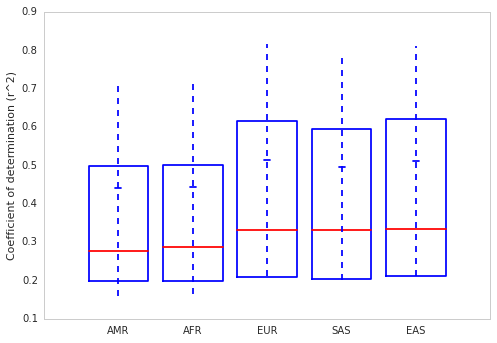

In [113]:
_ = boxplot_from_summary_stats(merged_rsquared_metrics,
                               position_col="population",
                               ylabel="Coefficient of determination (r^2)")

The boxplot of the r^2 measure of LD shows that the mean and median LD are highest for the European and East Asian superpopulations, and substantially lower for the African and Admixed American populations. This suggests that the larger total number of LD results in African and Admixed American populations (as evidenced by the barplot of LD results given above) may arise from rare haplotypes.

To investigate this hypothesis, we can examine the distribution of frequencies of the most rare haplotype in LD results.

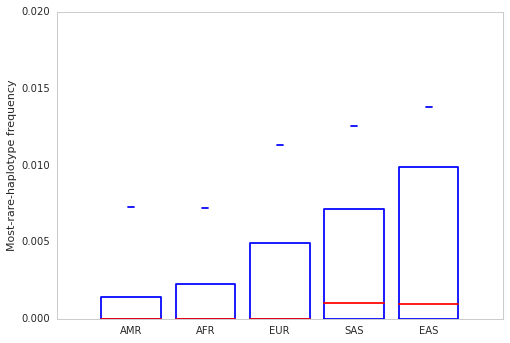

In [114]:
_ = boxplot_from_summary_stats(merged_maf_metrics,
                               position_col="population",
                               ylabel="Most-rare-haplotype frequency",
                               show_stddev=False,
                               ylim=[0, 0.02])

The boxplots of the frequency of the most rare haplotypes shows that the Admixed American and African superpopulations have a similar distribution of rare haplotypes included in their LD results. The superpopulation with the distribution of least-rare haplotypes is East Asian.

Taken together, the above results suggest that the grouping of populations into superpopulations introduces signals indicative of population stratification, particularly for the strongly heterogeneous "African" and "Admixed American" groups. Linkage disequilibrium and other genetic analyses subject to population stratification should ideally be performed on more genetically homogeneous subsets of data when possible.